In [1]:
 !mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb

Dataset URL: https://www.kaggle.com/datasets/safabouguezzi/german-traffic-sign-detection-benchmark-gtsdb
License(s): unknown


In [3]:
import zipfile

zip_data = zipfile.ZipFile('/content/german-traffic-sign-detection-benchmark-gtsdb.zip')
zip_data.extractall()
zip_data.close()

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Set Matplotlib style
plt.style.use("ggplot")

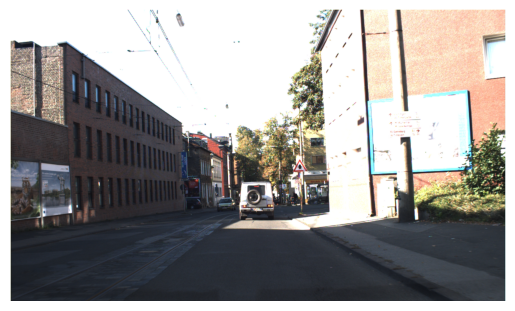

In [5]:
img = cv2.imread('/content/TrainIJCNN2013/TrainIJCNN2013/00000.ppm')

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis("off")
plt.show()

# EDA

In [6]:
# Define dataset directory
DATASET_PATH = "/content"
TRAIN_PATH = os.path.join(DATASET_PATH, "/content/TrainIJCNN2013/TrainIJCNN2013")  # Train images
TEST_PATH = os.path.join(DATASET_PATH, "/content/TestIJCNN2013/TestIJCNN2013Download")  # Test images
ANNOTATIONS_PATH = os.path.join(TRAIN_PATH, "gt.txt")  # Annotations

In [7]:
# Count number of images in training and test set
train_images = glob(os.path.join(TRAIN_PATH, "*.ppm"))  # Modify extension if needed
test_images = glob(os.path.join(TEST_PATH, "*.ppm"))

print(f"Total Training Images: {len(train_images)}")
print(f"Total Test Images: {len(test_images)}")

Total Training Images: 600
Total Test Images: 300


In [8]:
# Load annotations
col_names = ["filename", "x1", "y1", "x2", "y2", "class_id"]
df = pd.read_csv(ANNOTATIONS_PATH, sep=";", names=col_names)

# Display first few rows
df.head()

filename   x1   y1    x2   y2  class_id
0  00000.ppm  774  411   815  446        11
1  00001.ppm  983  388  1024  432        40
2  00001.ppm  386  494   442  552        38
3  00001.ppm  973  335  1031  390        13
4  00002.ppm  892  476  1006  592        39

<ipython-input-9-235bd43b9bfd>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="class_id", palette="viridis")


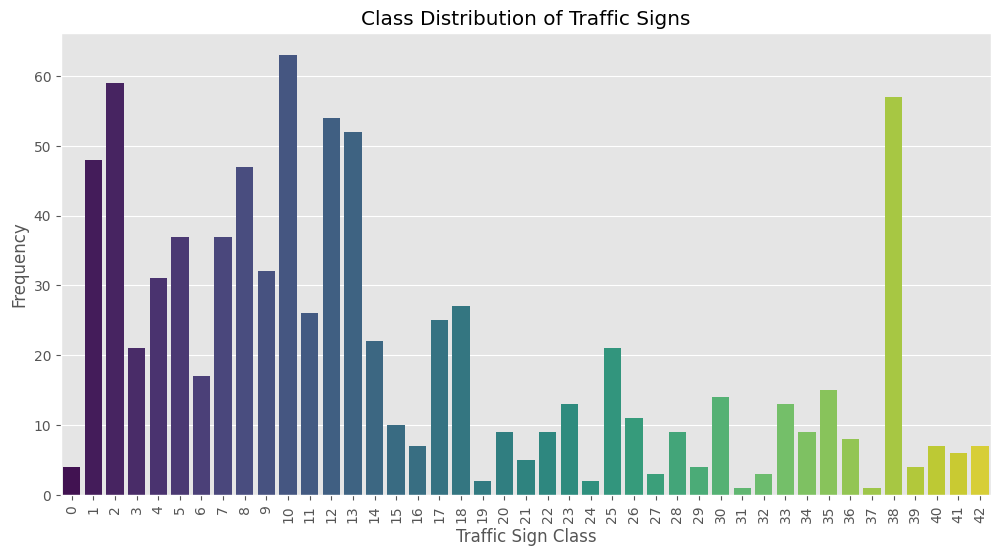

In [9]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="class_id", palette="viridis")
plt.xticks(rotation=90)
plt.title("Class Distribution of Traffic Signs")
plt.xlabel("Traffic Sign Class")
plt.ylabel("Frequency")
plt.show()

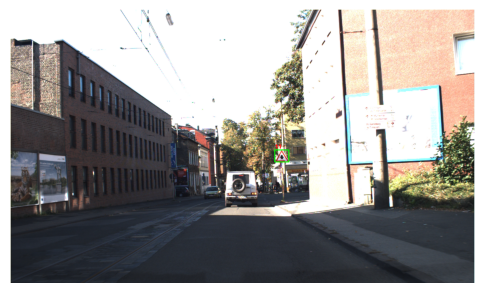

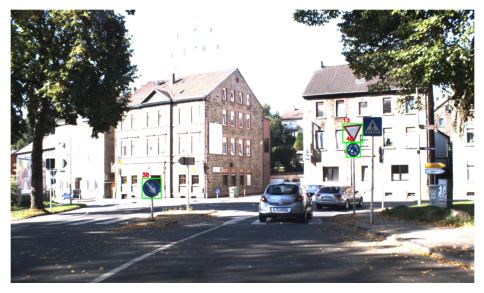

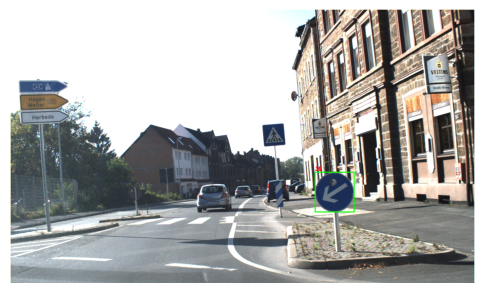

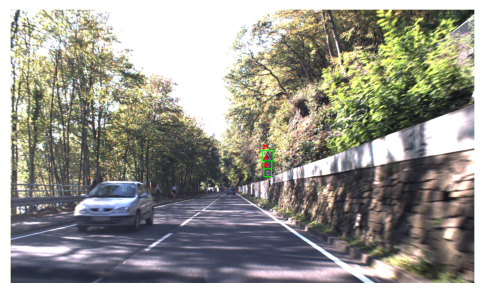

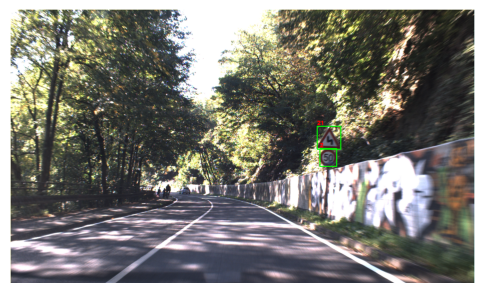

In [10]:
def show_image_with_bbox(image_name):
    # Load image
    img_path = os.path.join(TRAIN_PATH, image_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get bounding boxes for this image
    boxes = df[df["filename"] == image_name]

    # Draw bounding boxes
    for _, row in boxes.iterrows():
        cv2.rectangle(
            image,
            (row["x1"], row["y1"]),
            (row["x2"], row["y2"]),
            (0, 255, 0), 2  # Green box
        )
        cv2.putText(image, str(row["class_id"]), (row["x1"], row["y1"] - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Show image
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Show a few images
sample_images = df["filename"].unique()[:5]  # First 5 images
for img in sample_images:
    show_image_with_bbox(img)

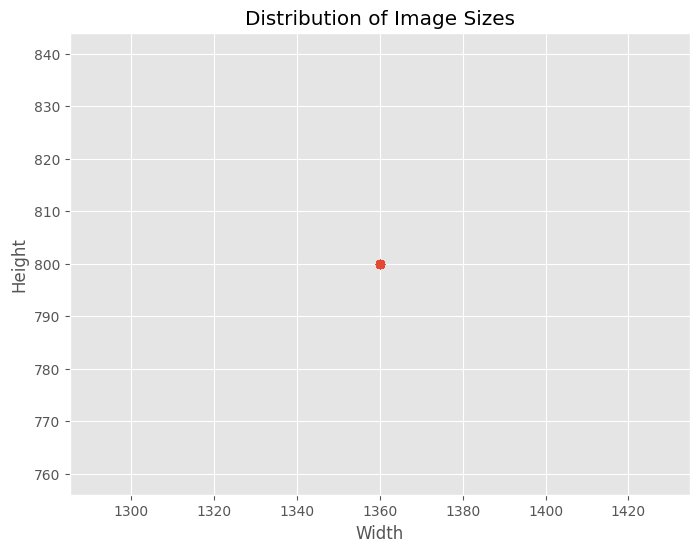

In [11]:
image_sizes = []
for img in train_images[:200]:  # Sample first 200 images
    img = cv2.imread(img)
    h, w = img.shape[:2]
    image_sizes.append((w, h))

image_sizes = np.array(image_sizes)
plt.figure(figsize=(8, 6))
plt.scatter(image_sizes[:, 0], image_sizes[:, 1], alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribution of Image Sizes")
plt.show()

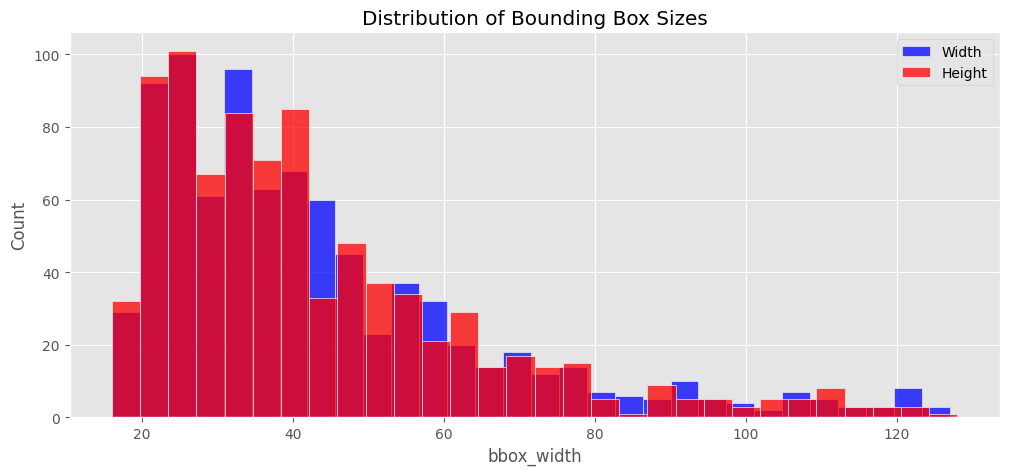

In [12]:
df["bbox_width"] = df["x2"] - df["x1"]
df["bbox_height"] = df["y2"] - df["y1"]

plt.figure(figsize=(12, 5))
sns.histplot(df["bbox_width"
], bins=30, color="blue", label="Width")
sns.histplot(df["bbox_height"], bins=30, color="red", label="Height")
plt.title("Distribution of Bounding Box Sizes")
plt.legend()
plt.show()

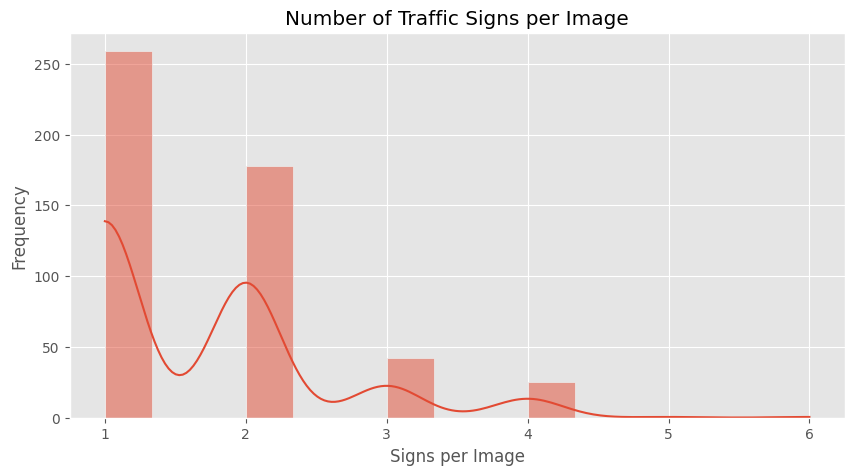

In [13]:
signs_per_image = df.groupby("filename").size()

plt.figure(figsize=(10, 5))
sns.histplot(signs_per_image, bins=15, kde=True)
plt.title("Number of Traffic Signs per Image")
plt.xlabel("Signs per Image")
plt.ylabel("Frequency")
plt.show()

In [14]:
import os

TRAIN_PATH = "/content/TrainIJCNN2013/TrainIJCNN2013"  # Path to train subfolder

# Get list of 43 class folders
class_folders = set(os.listdir(TRAIN_PATH))

# Iterate over files in train directory
for file in os.listdir(TRAIN_PATH):
    file_path = os.path.join(TRAIN_PATH, file)

    # If it's not a directory (i.e., an extra image), delete it
    if os.path.isfile(file_path):
        os.remove(file_path)

print("✅ Removed 600 full-street images. Now only 43 class folders remain.")


✅ Removed 600 full-street images. Now only 43 class folders remain.


# Data Preprocessing

In [15]:
import os

TRAIN_PATH = "/content/TrainIJCNN2013/TrainIJCNN2013"  # Path to train folder

def check_original_images(directory):
    total = 0
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            images = [f for f in os.listdir(folder_path) if f.endswith((".ppm"))]
            total += len(images)
            print(f"Class {folder}: {len(images)} images")
    print(f"\n📌 Total Images Before Splitting: {total}")

check_original_images(TRAIN_PATH)

Class 06: 17 images
Class 09: 32 images
Class 41: 6 images
Class 27: 3 images
Class 11: 26 images
Class 12: 54 images
Class 33: 13 images
Class 14: 22 images
Class 21: 5 images
Class 22: 9 images
Class 29: 4 images
Class 17: 25 images
Class 05: 37 images
Class 38: 57 images
Class 13: 52 images
Class 01: 48 images
Class 20: 9 images
Class 37: 1 images
Class 02: 59 images
Class 42: 7 images
Class 40: 8 images
Class 00: 4 images
Class 04: 31 images
Class 08: 47 images
Class 36: 8 images
Class 07: 37 images
Class 28: 9 images
Class 32: 3 images
Class 30: 14 images
Class 15: 10 images
Class 39: 4 images
Class 23: 13 images
Class 03: 21 images
Class 10: 63 images
Class 24: 2 images
Class 35: 15 images
Class 31: 1 images
Class 26: 11 images
Class 18: 27 images
Class 25: 21 images
Class 16: 7 images
Class 34: 9 images
Class 19: 2 images

📌 Total Images Before Splitting: 853


In [16]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to train and test folders
TRAIN_PATH = "/content/TrainIJCNN2013/TrainIJCNN2013"
TEST_PATH = "/content/TestIJCNN2013/TestIJCNN2013Download"

# Confirm the number of images in train and test
train_count = sum([len(files) for _, _, files in os.walk(TRAIN_PATH)])
test_count = sum([len(files) for _, _, files in os.walk(TEST_PATH)])

print(f"📌 Train Set: {train_count} images (Expected: 853)")
print(f"📌 Test Set: {test_count} images (Expected: 300)")

# Image data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(64, 64),  # Resize as needed
    batch_size=32,
    class_mode='categorical'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

print("✅ Train & Test Generators Ready!")

📌 Train Set: 853 images (Expected: 853)
📌 Test Set: 301 images (Expected: 300)
Found 853 images belonging to 43 classes.
Found 0 images belonging to 0 classes.
✅ Train & Test Generators Ready!



# Model Building

# MobileNetV2

In [22]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import shutil
import pandas as pd
import numpy as np

# Paths to train and test folders
TRAIN_PATH = "/content/TrainIJCNN2013/TrainIJCNN2013"  # 43 class subfolders
TEST_PATH = "/content/TestIJCNN2013/TestIJCNN2013Download"  # No subfolders yet
GT_FILE = "/content/gt.txt"  # Ground truth labels

# ✅ Create a single test subfolder (if not already exists)
TEST_SUBFOLDER = os.path.join(TEST_PATH, "unknown")
os.makedirs(TEST_SUBFOLDER, exist_ok=True)

# ✅ Move all test images into "unknown" subfolder
for file in os.listdir(TEST_PATH):
    if file.endswith(('.jpg', '.ppm')):  # Check for image files
        shutil.move(os.path.join(TEST_PATH, file), os.path.join(TEST_SUBFOLDER, file))

# ✅ Load ground truth labels from gt.txt
df_gt = pd.read_csv(GT_FILE, sep=";", header=None, names=["filename", "x1", "y1", "x2", "y2", "label"])
df_gt = df_gt[["filename", "label"]]
df_gt["label"] = df_gt["label"].astype(str)  # Convert to string for categorical mode
df_gt["filepath"] = df_gt["filename"].apply(lambda x: os.path.join(TEST_SUBFOLDER, x))
df_gt = df_gt[df_gt["filepath"].apply(os.path.exists)]  # Remove missing files

# Confirm dataset sizes
train_count = sum([len(files) for _, _, files in os.walk(TRAIN_PATH)])
test_count = len(df_gt)
print(f"📌 Train Set: {train_count} images (Expected: 853)")
print(f"📌 Test Set: {test_count} images (Expected: 300)")

# ✅ Image data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

# ✅ Train generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH, target_size=(96, 96), batch_size=16, class_mode='categorical', subset="training"
)

# ✅ Validation generator
val_generator = train_datagen.flow_from_directory(
    TRAIN_PATH, target_size=(96, 96), batch_size=16, class_mode='categorical', subset="validation"
)

# ✅ Test generator (with labels from gt.txt)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_gt, x_col="filepath", y_col="label",
    target_size=(96, 96), batch_size=16, class_mode="categorical", shuffle=False
)

# ✅ Load MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze all layers except last 20
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# ✅ Custom head for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

# ✅ Build model
model = Model(inputs=base_model.input, outputs=outputs)

# ✅ Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train model
epochs = 20
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

# ✅ Save model
model.save("traffic_sign_model.h5")
print("✅ Model Training Complete & Saved!")

# ✅ Predict on test set
predictions = model.predict(test_generator)
print("✅ Test Predictions Done!")

📌 Train Set: 853 images (Expected: 853)
📌 Test Set: 476 images (Expected: 300)
Found 702 images belonging to 43 classes.
Found 151 images belonging to 43 classes.
Found 476 validated image filenames belonging to 42 classes.
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 32s 378ms/step - accuracy: 0.0048 - loss: 4.7081 - val_accuracy: 0.0199 - val_loss: 3.7695
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.0431 - loss: 3.9713 - val_accuracy: 0.0795 - val_loss: 3.5363
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.0548 - loss: 3.6945 - val_accuracy: 0.1854 - val_loss: 3.4015
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.0754 - loss: 3.6112 - val_accuracy: 0.2053 - val_loss: 3.2514
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.0962 - loss: 3.5292 - val_accuracy: 0.2583 - val_loss: 3.0402
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.1384 - loss: 3.3472 - val_accuracy: 0.2384 - val_loss: 2.9426
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.1816 - loss: 3.2462 - val_accuracy: 0.2781 - val_loss: 2.8463
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.1909 - loss: 3.1704 - val_accuracy: 0.3046 - val_loss:

✅ Model Training Complete & Saved!
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step
✅ Test Predictions Done!


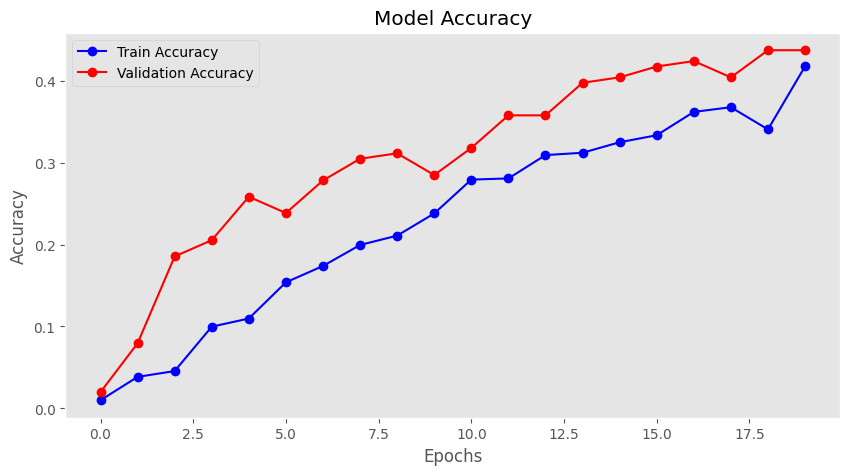

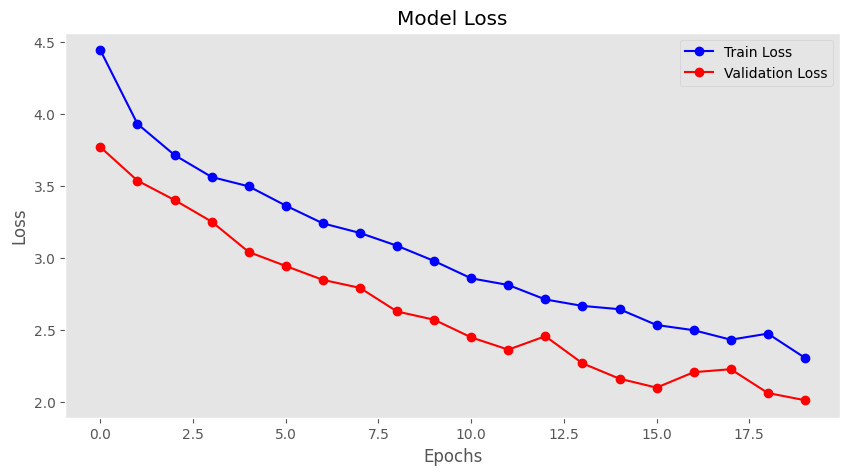

In [23]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.show()

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 48, 48, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 48, 48, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 48, 48, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 48, 48, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 48, 48, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 48, 48, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 48, 48, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 48, 48, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 48, 48, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 49, 49, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 24, 24, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 5,769,283 (22.01 MB)

 Trainable params: 1,572,459 (6.00 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

 Optimizer params: 3,144,920 (12.00 MB)

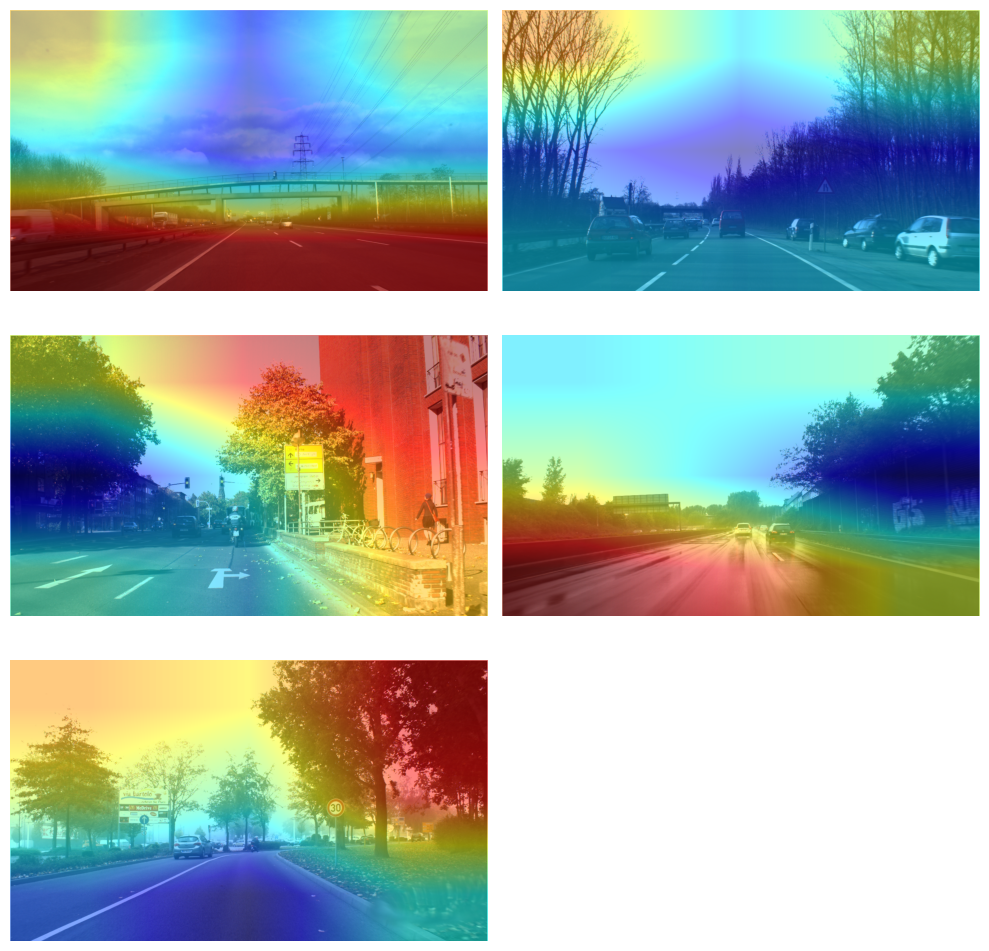

In [21]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load trained model
model = load_model('traffic_sign_model.h5')  # Change to your model's filename

# Define Grad-CAM function
def get_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap[0], 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

# Function to overlay heatmap on image
def overlay_heatmap(img_path, heatmap, alpha=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

# Select 5 random test images (update paths)
test_image_paths = [
    "/content/TestIJCNN2013/TestIJCNN2013Download/unknown/00000.ppm", "/content/TestIJCNN2013/TestIJCNN2013Download/unknown/00007.ppm", "/content/TestIJCNN2013/TestIJCNN2013Download/unknown/00043.ppm",
    "/content/TestIJCNN2013/TestIJCNN2013Download/unknown/00087.ppm", "/content/TestIJCNN2013/TestIJCNN2013Download/unknown/00080.ppm"
]  # Replace with actual paths

# Visualize Grad-CAM for each image
layer_name = "Conv_1"  # Last Conv layer in MobileNetV2
plt.figure(figsize=(10, 10))

for i, img_path in enumerate(test_image_paths):
    img = image.load_img(img_path, target_size=(96, 96))  # Change size as per your model input
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap = get_gradcam(model, img_array, layer_name)
    superimposed_img = overlay_heatmap(img_path, heatmap)

    plt.subplot(3, 2, i+1)
    plt.imshow(superimposed_img)
    plt.axis("off")

plt.tight_layout()
plt.show()

# ResNet-50

In [22]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import shutil
import pandas as pd
import numpy as np

# Paths to train and test folders
TRAIN_PATH = "/content/TrainIJCNN2013/TrainIJCNN2013"  # 43 class subfolders
TEST_PATH = "/content/TestIJCNN2013/TestIJCNN2013Download"  # No subfolders yet
GT_FILE = "/content/gt.txt"  # Ground truth labels

# ✅ Create a single test subfolder (if not already exists)
TEST_SUBFOLDER = os.path.join(TEST_PATH, "unknown")
os.makedirs(TEST_SUBFOLDER, exist_ok=True)

# ✅ Move all test images into "unknown" subfolder
for file in os.listdir(TEST_PATH):
    if file.endswith(('.jpg', '.ppm')):  # Check for image files
        shutil.move(os.path.join(TEST_PATH, file), os.path.join(TEST_SUBFOLDER, file))

# ✅ Load ground truth labels from gt.txt
df_gt = pd.read_csv(GT_FILE, sep=";", header=None, names=["filename", "x1", "y1", "x2", "y2", "label"])
df_gt = df_gt[["filename", "label"]]
df_gt["label"] = df_gt["label"].astype(str)  # Convert to string for categorical mode
df_gt["filepath"] = df_gt["filename"].apply(lambda x: os.path.join(TEST_SUBFOLDER, x))
df_gt = df_gt[df_gt["filepath"].apply(os.path.exists)]  # Remove missing files

# Confirm dataset sizes
train_count = sum([len(files) for _, _, files in os.walk(TRAIN_PATH)])
test_count = len(df_gt)
print(f"📌 Train Set: {train_count} images (Expected: 853)")
print(f"📌 Test Set: {test_count} images (Expected: 300)")

# ✅ Image data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# ✅ Train generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH, target_size=(96, 96), batch_size=16, class_mode='categorical', subset="training"
)

# ✅ Validation generator
val_generator = train_datagen.flow_from_directory(
    TRAIN_PATH, target_size=(96, 96), batch_size=16, class_mode='categorical', subset="validation"
)

# ✅ Test generator (with labels from gt.txt)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_gt, x_col="filepath", y_col="label",
    target_size=(96, 96), batch_size=16, class_mode="categorical", shuffle=False
)

# ✅ Load ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze all layers except last 20
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# ✅ Custom head for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

# ✅ Build model
model = Model(inputs=base_model.input, outputs=outputs)

# ✅ Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# ✅ Train model
epochs = 20
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

# ✅ Save model
model.save("traffic_sign_resnet50.h5")
print("✅ Model Training Complete & Saved!")

# ✅ Predict on test set
predictions = model.predict(test_generator)
print("✅ Test Predictions Done!")

📌 Train Set: 853 images (Expected: 853)
📌 Test Set: 476 images (Expected: 300)
Found 702 images belonging to 43 classes.
Found 151 images belonging to 43 classes.
Found 476 validated image filenames belonging to 42 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 366ms/step - accuracy: 0.0572 - loss: 3.8230 - val_accuracy: 0.0728 - val_loss: 3.6645
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.1946 - loss: 3.2273 - val_accuracy: 0.0728 - val_loss: 3.5857
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2665 - loss: 2.8828 - val_accuracy: 0.0596 - val_loss: 3.5516
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.2958 - loss: 2.7360 - val_accuracy: 0.1126 - val_loss: 3.5218
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3301 - loss: 2.5386 - val_accuracy: 0.1391 - val_loss: 3.4740
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3561 - loss: 2.3757 - val_accuracy: 0.1523 - val_loss: 3.3720
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3751 - loss: 2.3095 - val_accuracy: 0.1523 - val_loss: 3.1899
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3889 - loss: 2.1967 - val_accuracy: 0.1589 - val_loss:

✅ Model Training Complete & Saved!
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step
✅ Test Predictions Done!


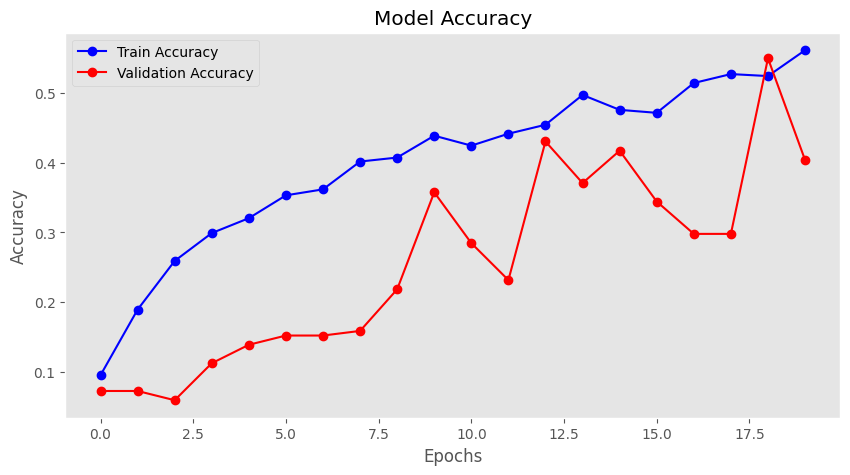

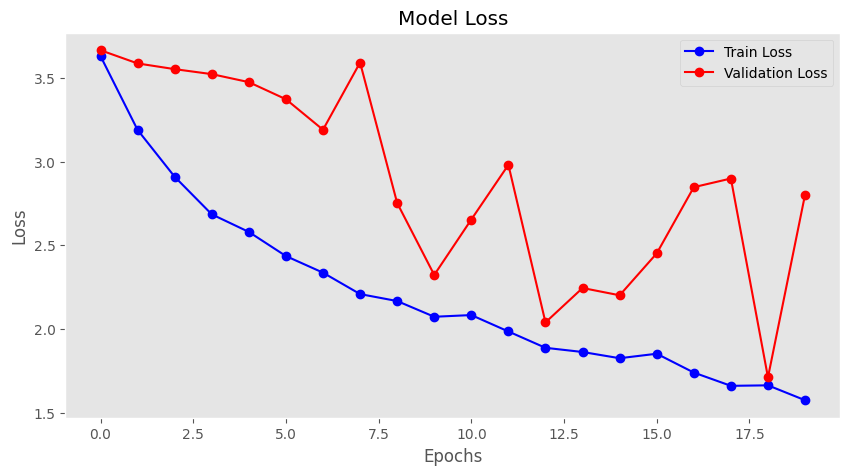

In [23]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', color='blue', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid()
plt.show()

In [24]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 102, 102, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 48, 48, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 48, 48, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 48, 48, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 50, 50, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 24, 24, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 24, 24, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 24, 24, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 24, 24, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 24, 24, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 24, 24, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 24, 24, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 24, 24, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 24, 24, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 43,139,331 (164.56 MB)

 Trainable params: 9,494,315 (36.22 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

 Optimizer params: 18,988,632 (72.44 MB)

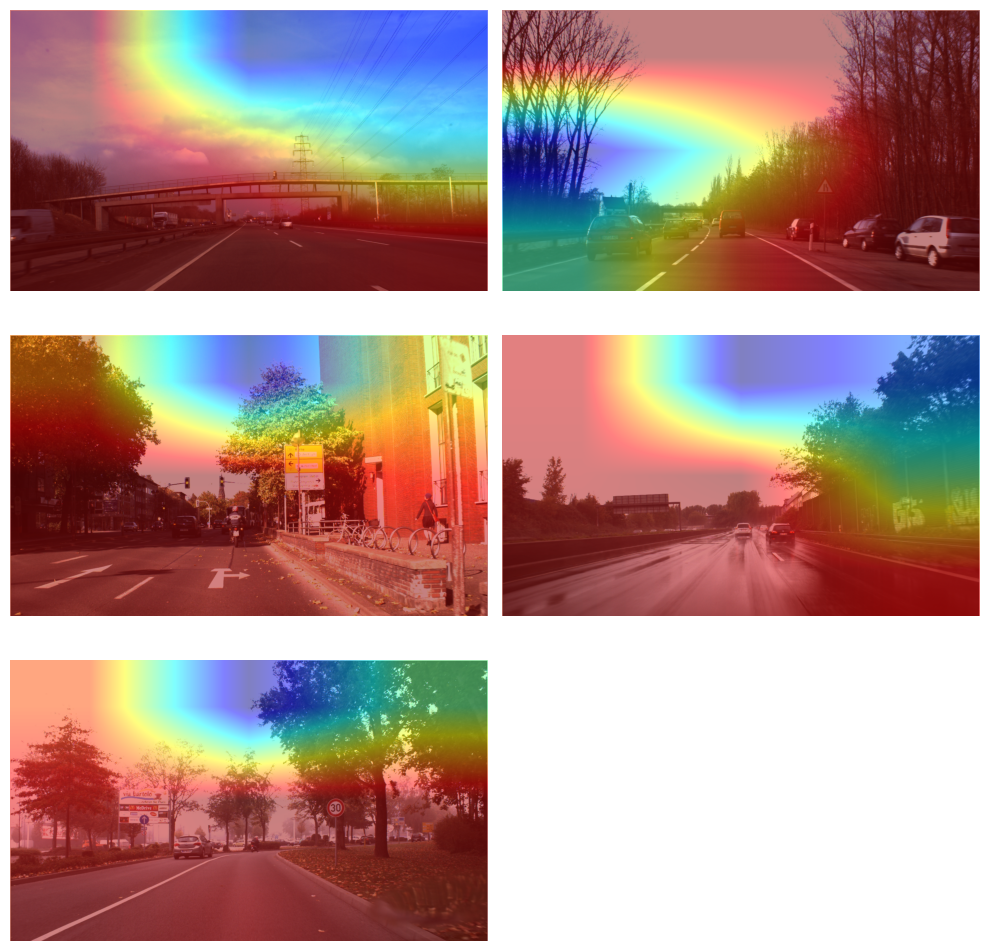

In [25]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# ✅ Load trained ResNet-50 model
model = load_model('traffic_sign_resnet50.h5')  # Update with your model filename

# ✅ Define Grad-CAM function for ResNet-50
def get_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap[0], 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize

    return heatmap

# ✅ Function to overlay heatmap on image
def overlay_heatmap(img_path, heatmap, alpha=0.5):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

# ✅ Select 5 random test images (update paths)
test_image_paths = [
    "/content/TestIJCNN2013/TestIJCNN2013Download/unknown/00000.ppm",
    "/content/TestIJCNN2013/TestIJCNN2013Download/unknown/00007.ppm",
    "/content/TestIJCNN2013/TestIJCNN2013Download/unknown/00043.ppm",
    "/content/TestIJCNN2013/TestIJCNN2013Download/unknown/00087.ppm",
    "/content/TestIJCNN2013/TestIJCNN2013Download/unknown/00080.ppm"
]  # Replace with actual paths

# ✅ Set the last convolutional layer in ResNet-50
layer_name = "conv5_block3_out"  # Last Conv layer in ResNet-50

# ✅ Visualize Grad-CAM for each image
plt.figure(figsize=(10, 10))

for i, img_path in enumerate(test_image_paths):
    img = image.load_img(img_path, target_size=(96, 96))  # Resize as per model input
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    heatmap = get_gradcam(model, img_array, layer_name)
    superimposed_img = overlay_heatmap(img_path, heatmap)

    plt.subplot(3, 2, i+1)
    plt.imshow(superimposed_img)
    plt.axis("off")

plt.tight_layout()
plt.show()

# Results and Observations

In [26]:
import os
import shutil

test_dir = "/content/TestIJCNN2013/TestIJCNN2013Download"
unknown_dir = os.path.join(test_dir, "unknown")

for file in os.listdir(unknown_dir):
    shutil.move(os.path.join(unknown_dir, file), test_dir)

os.rmdir(unknown_dir)  # Remove empty folder

    filename label
0  00000.ppm    11
1  00001.ppm    40
4  00002.ppm    39
5  00003.ppm     4
8  00004.ppm    21
Found 295 validated image filenames belonging to 42 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 211 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 366ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 463ms/step
Classification Report for MobileNetV2:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      0.03      0.06        30
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        15
           6       0.20      0.09      0.12        11
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         4
          10       0.04      0.75      0.08        12
          11       0.00      0.00      0.00         1
          12       0.11      0.20      0.14        30
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         3
          15  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


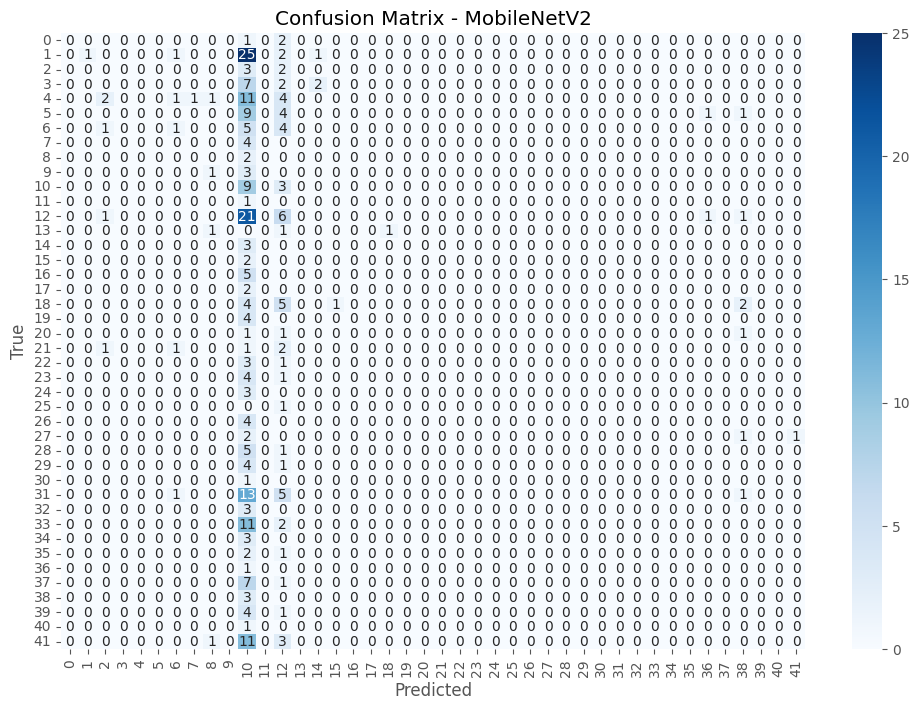

Classification Report for ResNet50:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00        11
           7       0.00      0.00      0.00         4
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00        12
          11       0.00      0.00      0.00         1
          12       0.13      0.27      0.17        30
          13       0.01      0.33      0.02         3
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


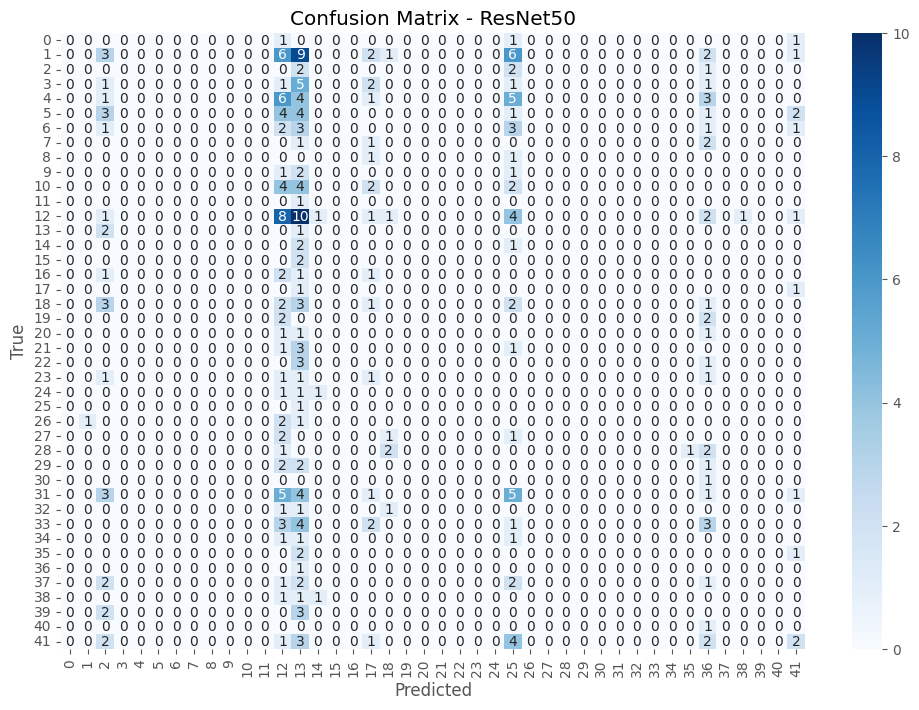

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Define paths
test_dir = "/content/TestIJCNN2013/TestIJCNN2013Download"  # Update this path accordingly
gt_path = "/content/gt.txt"

# Load gt.txt (semicolon-separated)
df_gt = pd.read_csv(gt_path, sep=";", header=None, names=["filename", "x1", "y1", "x2", "y2", "label"])

# Drop duplicate filenames, keeping only the first occurrence
df_test = df_gt[["filename", "label"]].drop_duplicates(subset="filename")

# Convert integer labels to string (Fix for flow_from_dataframe)
df_test["label"] = df_test["label"].astype(str)

# Verify dataset
print(df_test.head())

# Image preprocessing
test_datagen = ImageDataGenerator(rescale=1./255)

# Create test generator using gt.txt data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=test_dir,  # Folder containing test images
    x_col="filename",    # Column with image filenames
    y_col="label",       # Column with class labels (Now as strings)
    target_size=(96, 96),  # Match model input size
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Load trained models
mobilenet_model = load_model("traffic_sign_model.h5")
resnet50_model = load_model("traffic_sign_resnet50.h5")

# Get true labels
y_true = test_generator.classes

# Make predictions
y_pred_mobilenet = np.argmax(mobilenet_model.predict(test_generator), axis=1)
y_pred_resnet50 = np.argmax(resnet50_model.predict(test_generator), axis=1)

# Classification report and confusion matrix function
def evaluate_model(y_true, y_pred, model_name):
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Evaluate both models
evaluate_model(y_true, y_pred_mobilenet, "MobileNetV2")
evaluate_model(y_true, y_pred_resnet50, "ResNet50")

In [28]:
print(f"Train: {train_generator.samples}, Validation: {val_generator.samples}, Test: {test_generator.samples}")


Train: 702, Validation: 151, Test: 295
